# How to pass custom LangSmith run ID for graph runs

Debugging your graph runs can sometimes be difficult to do in your IDE or terminal. LangSmith lets you use trace data to debug, test, and monitor your LLM app — creating a virtuous data flywheel for improvement as your application evolves.

In order to make it simple to find your graph run in LangSmith, you can pass in a custom `run_id` to the configuration of your graph invocation.

## Setup

First, let's install the required packages and set our API keys

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

<div class="admonition tip">
     <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for better debugging</p>
     <p style="padding-top: 5px;">
         Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM aps built with LangGraph — read more about how LangSmith can help you in the <a href="https://docs.smith.langchain.com">docs</a>. 
     </p>
 </div>

## Define the graph

For this example we will use the [prebuilt ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/).

In [2]:
from langchain_openai import ChatOpenAI
from typing import Literal
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

# First we initialize the model we want to use.
model = ChatOpenAI(model="gpt-4o", temperature=0)


# For this tutorial we will use custom tool that returns pre-defined values for weather in two cities (NYC & SF)
@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It might be cloudy in nyc"
    elif city == "sf":
        return "It's always sunny in sf"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]


# Define the graph
graph = create_react_agent(model, tools=tools)

## Run your graph

Now that we've defined our graph let's run it once and view the trace in LangSmith. In order for our trace to be easily accessible in LangSmith, we will pass in a custom `run_id` in the config.

This assumes that you have set your `LANGCHAIN_API_KEY` environment variable.

Note that you can also configure what project to trace to by setting the `LANGCHAIN_PROJECT` environment variable, by default runs will be traced to the `default` project.

In [4]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()
inputs = {"messages": [("user", "what is the weather in sf")]}
config = {"configurable": {"run_id":"12345"}}

print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_qpjGVrF4bNSJ5NarwjH2FTBJ)
 Call ID: call_qpjGVrF4bNSJ5NarwjH2FTBJ
  Args:
    city: sf
================================= Tool Message =================================
Name: get_weather

It's always sunny in sf
================================== Ai Message ==================================

The weather in San Francisco is currently sunny.


## View the trace in LangSmith

Now that we've ran our graph, let's head over to LangSmith and view our trace. First click into the project that you traced to (in our case the default project). Next, let's add a filter to search for the run with the id ("12345") that we set above. You can do this by clicking the filter button which is near the top left of the project view (right under the "Runs" tab), you will then want to set a filter that looks something like this:

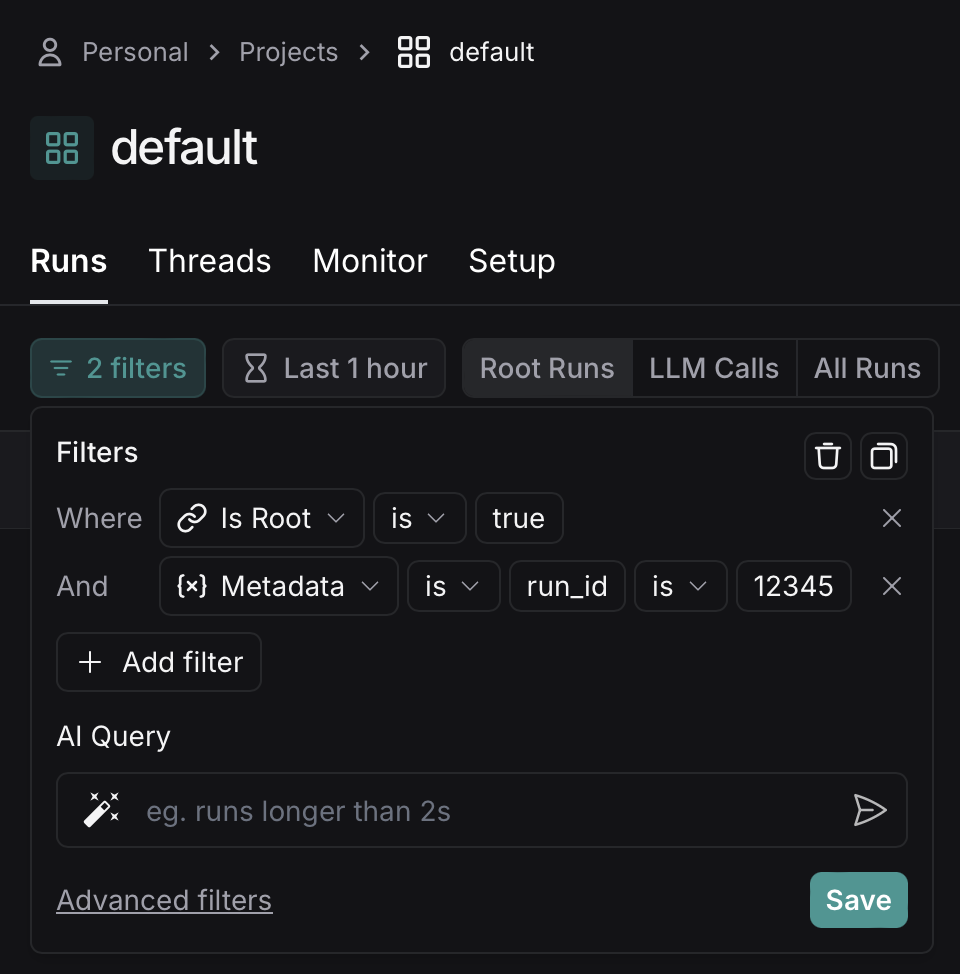

After setting the filter, you will see the corresponding graph run show up, and you can click on it to give you a more detailed view, which would look like this for the case above:

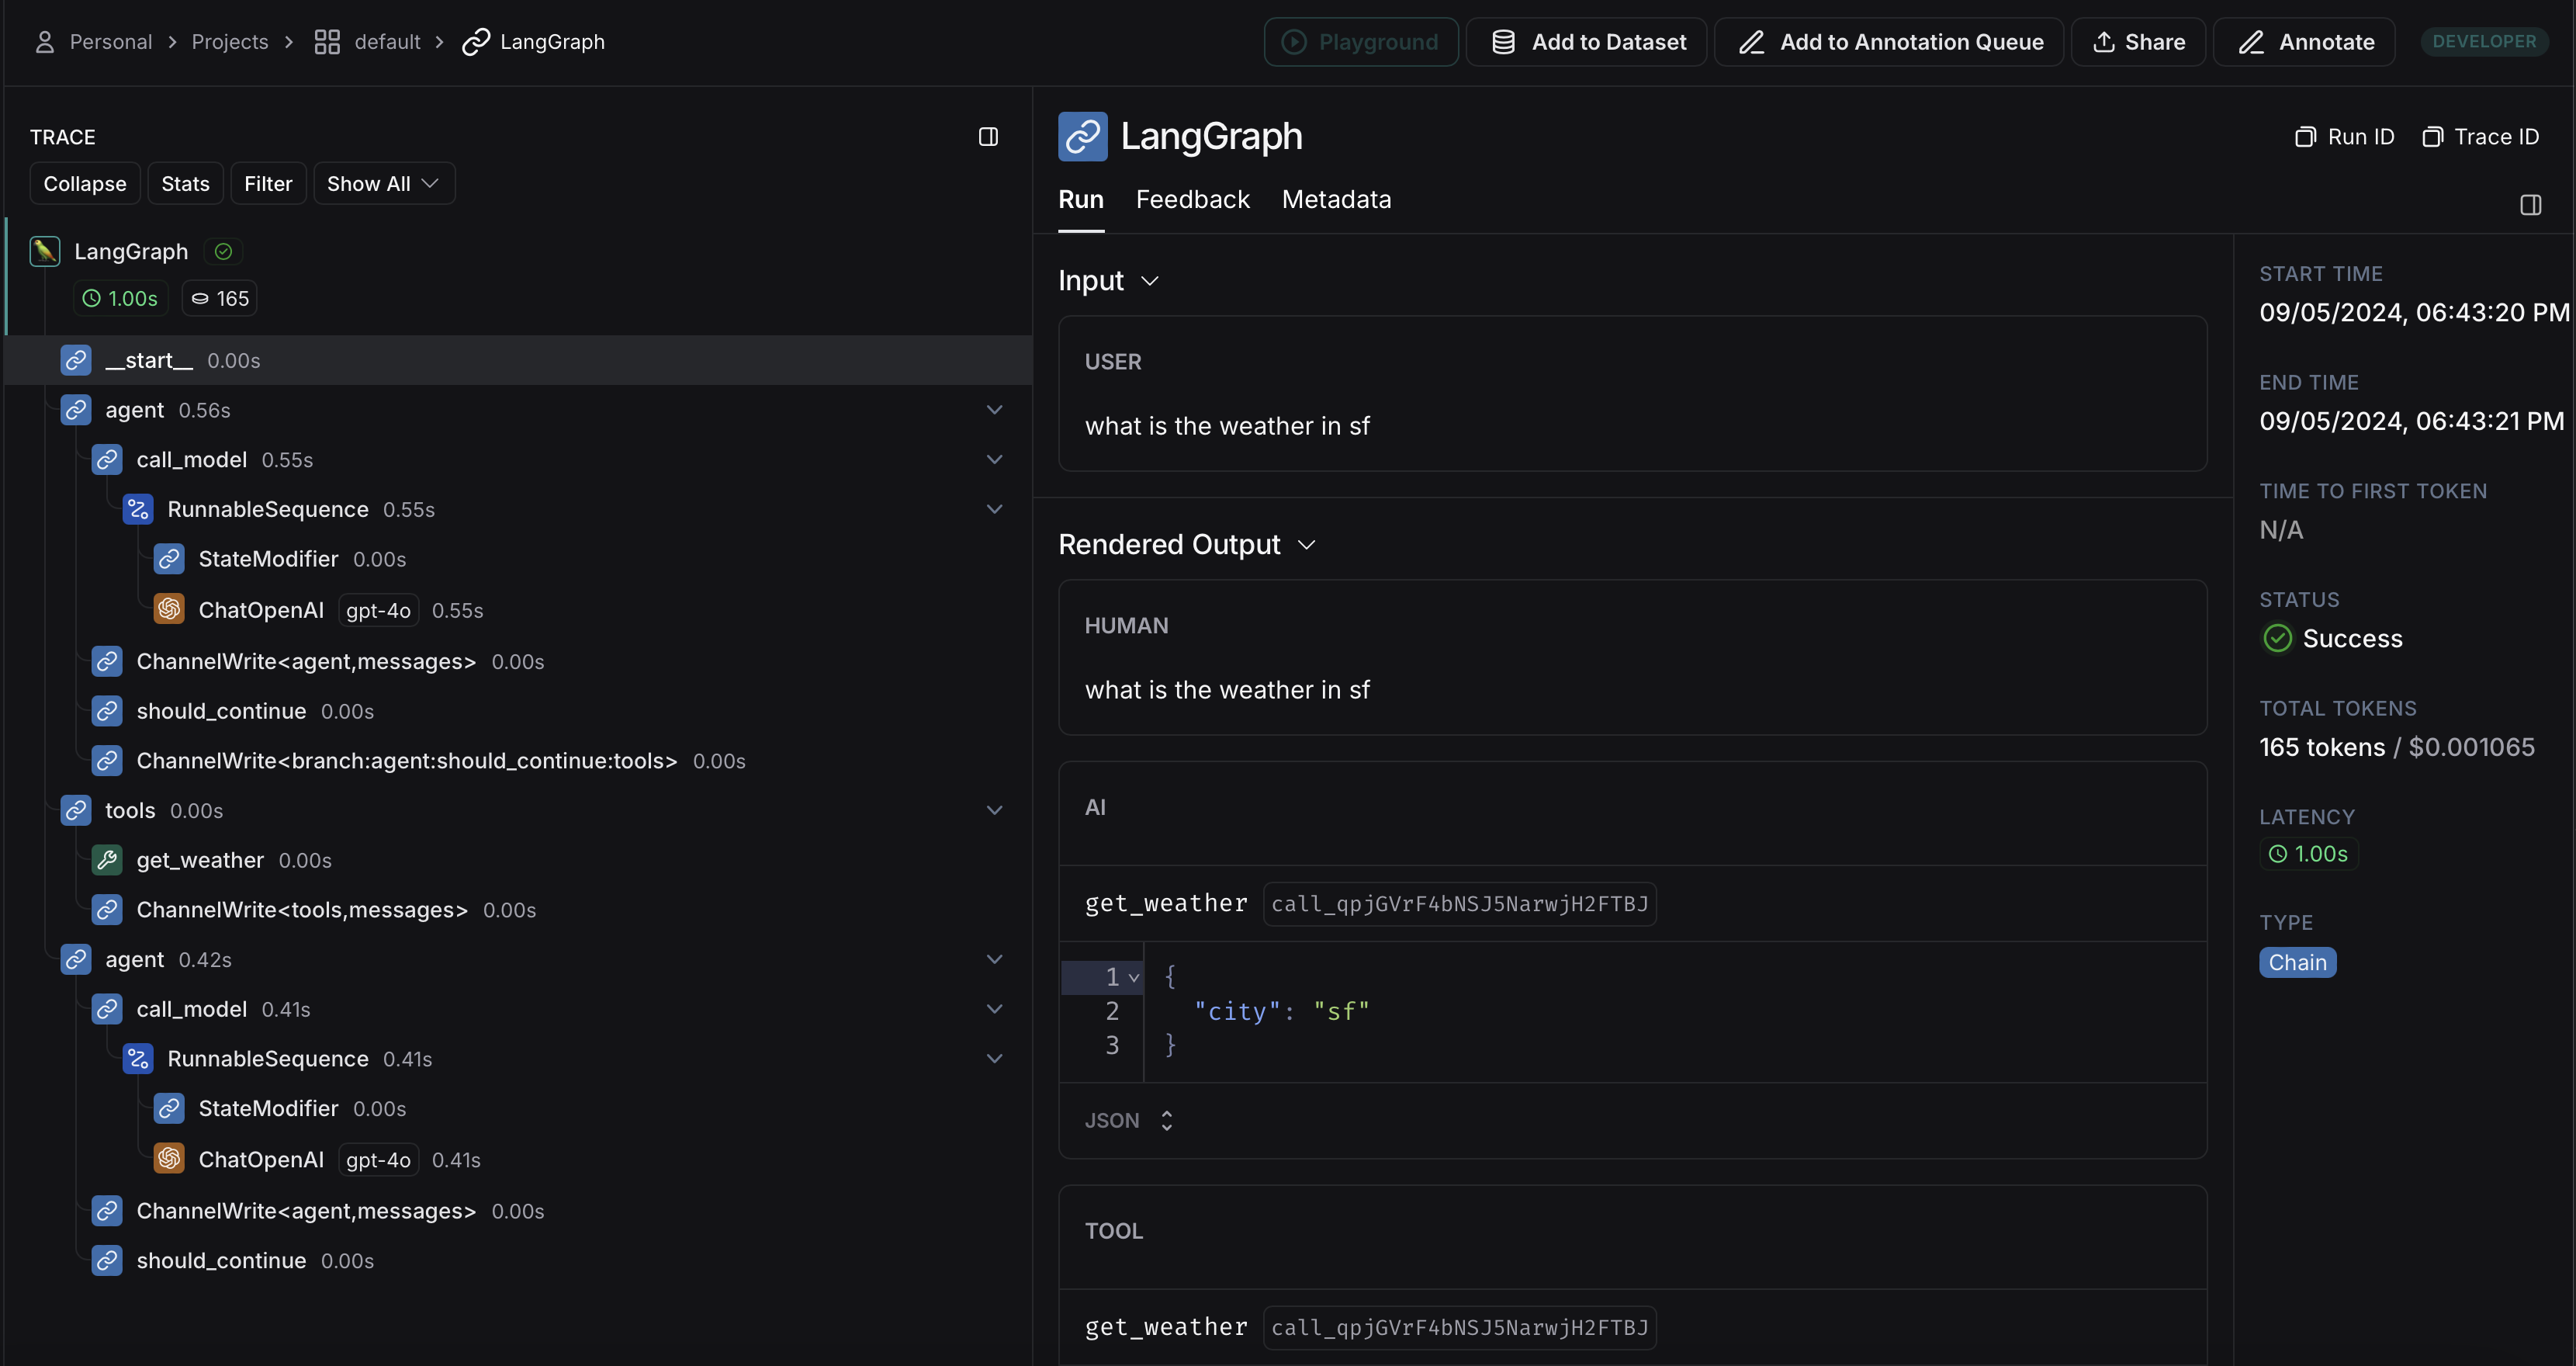